In [1]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import os
from copy import deepcopy
from utils.tddfa_util import str2bool
from fdc_utils import *
import argparse

parser = argparse.ArgumentParser(description='The demo of still image of 3DDFA_V2')
parser.add_argument('-c', '--config', type=str, default='configs/mb1_120x120.yml')
parser.add_argument('-f', '--img_fp', type=str, default='examples/inputs/trump_hillary.jpg')
parser.add_argument('-m', '--mode', type=str, default='cpu', help='gpu or cpu mode')
parser.add_argument('-o', '--opt', type=str, default='2d_sparse', choices=['2d_sparse', '2d_dense', '3d', 'depth', 'pncc', 'uv_tex', 'pose', 'ply', 'obj'])
parser.add_argument('--onnx', action='store_true', default=False)
parser.add_argument('--video_path_parent', type=str, default='/nfs/STG/Audio2FacePose/MEAD/New_frames_1')
parser.add_argument('--side_view', type=str, default='top') # 'top'; 'left_60'; 'right_60'
parser.add_argument('--ldmk_part', type=str, default='full') # 'full'; 'non-cheek'; 'left'; 'right'; 'mouth'
args = parser.parse_args()

exp = 'angry'
level = 'level_3'
clip = '001'

train_video_list = ['video_001']

# test_video_list = ['video_002']
num_image = 25
distortion_mode_list = ['tangential', 'none', 'radial', 'combined']

/home/uss00067/anaconda3/envs/facial/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tqdm import tqdm

def extract_ldmks(src_image_path, gt_image_path, args):
    src_image = cv2.imread(src_image_path)
    gt_image = cv2.imread(gt_image_path)

    src_raw_landmarks = detect_attributes(src_image, args)
    gt_raw_landmarks = detect_attributes(gt_image, args)

    new_src_image = detect_face(src_image, src_raw_landmarks)
    new_gt_image = detect_face(gt_image, gt_raw_landmarks)

    src_landmarks = detect_attributes(new_src_image, args)
    gt_landmarks = detect_attributes(new_gt_image, args)

    if args.ldmk_part == 'non-cheek':
        src_u = src_landmarks[0, :][17:]
        src_v = src_landmarks[1, :][17:]
        src_z = src_landmarks[2, :][17:]

        gt_u = gt_landmarks[0, :][17:]
        gt_v = gt_landmarks[1, :][17:]
        gt_z = gt_landmarks[2, :][17:]
        
        first_idx = 39-17
        second_idx = 42-17
        third_idx = 48-17
        last_idx = 54-17
    elif args.ldmk_part == 'full':
        src_u = src_landmarks[0, :]
        src_v = src_landmarks[1, :]
        src_z = src_landmarks[2, :]

        gt_u = gt_landmarks[0, :]
        gt_v = gt_landmarks[1, :]
        gt_z = gt_landmarks[2, :]
        
        first_idx = 17
        second_idx = 26
        third_idx = 48
        last_idx = 54
    elif args.ldmk_part == 'left':
#         src_u = src_landmarks[0, 42:48]
#         src_v = src_landmarks[1, 42:48]
#         src_z = src_landmarks[2, 42:48]

#         gt_u = gt_landmarks[0, 42:48]
#         gt_v = gt_landmarks[1, 42:48]
#         gt_z = gt_landmarks[2, 42:48]
        
#         first_idx = 42-42
#         second_idx = 44-42
#         third_idx = 45-42
#         last_idx = 46-42
        print(type(src_landmarks))
        src_u = np.concatenate([src_landmarks[0, 42:48], src_landmarks[0, 22:27]])
        src_v = np.concatenate([src_landmarks[1, 42:48], src_landmarks[1, 22:27]])
        src_z = np.concatenate([src_landmarks[2, 42:48], src_landmarks[2, 22:27]])

        gt_u = np.concatenate([gt_landmarks[0, 42:48], gt_landmarks[0, 22:27]])
        gt_v = np.concatenate([gt_landmarks[1, 42:48], gt_landmarks[1, 22:27]])
        gt_z = np.concatenate([gt_landmarks[2, 42:48], gt_landmarks[2, 22:27]])
        
        first_idx = 42-42
        second_idx = 45-42
        third_idx = 48-42+22-22
        last_idx = 48-42+26-22
        
        print('length of src_u: ', src_u.shape[0])
        print('first idx: ', first_idx)
        print('second idx: ', second_idx)
        print('third idx: ', third_idx)
        print('last idx: ', last_idx)
    elif args.ldmk_part == 'right':
        src_u = src_landmarks[0, 36:42]
        src_v = src_landmarks[1, 36:42]
        src_z = src_landmarks[2, 36:42]

        gt_u = gt_landmarks[0, 36:42]
        gt_v = gt_landmarks[1, 36:42]
        gt_z = gt_landmarks[2, 36:42]
        
        first_idx = 36-36
        second_idx = 38-36
        third_idx = 39-36
        last_idx = 40-36
    elif args.ldmk_part == 'mouth':
        src_u = src_landmarks[0, 48:68]
        src_v = src_landmarks[1, 48:68]
        src_z = src_landmarks[2, 48:68]

        gt_u = gt_landmarks[0, 48:68]
        gt_v = gt_landmarks[1, 48:68]
        gt_z = gt_landmarks[2, 48:68]
        
        first_idx = 48-48
        second_idx = 51-48
        third_idx = 54-48
        last_idx = 57-48
    
    four_idx_list = [first_idx, second_idx, third_idx, last_idx]
    new_image_shape = [new_src_image.shape[0], new_src_image.shape[1]]
    return src_u, src_v, gt_u, gt_v, four_idx_list, new_image_shape

def warp_src_ldmks(src_u, src_v, matrix):
    long_ones_vec = np.ones((src_u.shape[0]))[:, np.newaxis]
    new_src_ldmks = np.hstack((src_u[:, np.newaxis], src_v[:, np.newaxis], long_ones_vec)).transpose()
    warped_src_ldmks = np.matmul(matrix, new_src_ldmks)
    normalized_warped_src_ldmks = warped_src_ldmks / warped_src_ldmks[2, :]
    return normalized_warped_src_ldmks

# Reference: https://towardsdatascience.com/camera-calibration-with-example-in-python-5147e945cdeb

from scipy.optimize import minimize

def geometric_error(m, gt_pts, pred_pts, distortion_mode):
    assert gt_pts.shape[1] == pred_pts.shape[1] # Check the number of the pts
    error = 0
    n_points = gt_pts.shape[1]
    for i in range(n_points):
        X, Y, Z, r = pred_pts[:, i]
        u, v = gt_pts[:, i]

        u_ = m[0] * X + m[1] * Y + m[2] * Z
        v_ = m[3] * X + m[4] * Y + m[5] * Z
        d = m[6] * X + m[7] * Y +  1 * Z 
        original_u_ = u_/d
        original_v_ = v_/d
        
        if distortion_mode == 'radial':
            u_ = original_u_ * (1 + m[8] * r**2 + m[9] * r**4)
            v_ = original_v_ * (1 + m[8] * r**2 + m[9] * r**4)
        elif distortion_mode == 'tangential':
            u_ = 2 * m[10] * original_u_ * original_v_ + m[11] * (r**2 + 2 * original_u_**2)
            v_ = m[10] * (r**2 + 2 * original_v_**2) + 2 * m[11] * original_u_ * original_v_
        elif distortion_mode == 'combined':
            u_ = original_u_ * (1 + m[8] * r**2 + m[9] * r**4) + 2 * m[10] * original_u_ * original_v_ + m[11] * (r**2 + 2 * original_u_**2)
            v_ = original_v_ * (1 + m[8] * r**2 + m[9] * r**4) + m[10] * (r**2 + 2 * original_v_**2) + 2 * m[11] * original_u_ * original_v_
        elif distortion_mode == 'none':
            u_ = original_u_
            v_ = original_v_
            
        # if distortion_mode == 'combined':
        #     print('u_: ', u_)
        #     print('v_: ', v_)
        #     print('error: ', error)
            
        error += np.sqrt(np.square(u - u_) + np.square(v - v_))
        
    return error

def compute_relative_error(src_pts, pred_pts, gt_pts):
    dist_1 = np.mean(np.sqrt((src_pts[:, 0] - gt_pts[:, 0])**2 + (src_pts[:, 1] - gt_pts[:, 1])**2))
    dist_2 = np.mean(np.sqrt((pred_pts[:, 0] - gt_pts[:, 0])**2 + (pred_pts[:, 1] - gt_pts[:, 1])**2))
    relative_error = (dist_1 - dist_2) / (dist_1)
    return relative_error

def run(video_list):
    vis_ldmks = {
        'vis_src_ldmks': [],
        'vis_gt_ldmks': [],
        'four_point_vis_src_pred_ldmks':[],
        'ransac_vis_src_pred_ldmks':[],
        'vis_ls_h_pred_ldmks':[],
        'vis_radial_pred_ldmks':[],
        'vis_tangential_pred_ldmks':[],
        'vis_combined_pred_ldmks':[]
    }

    matrices = {
        'four_point': None,
        'ransac': None,
        'ls_h': None,
        'radial': None,
        'tangential': None,
        'combined': None
    }

    errors = {
        'four_point': [],
        'ransac': [],
        'ls_h': [],
        'radial': [],
        'tangential': [],
        'combined': []
    }

    # Loop over training/testing set
    for video in video_list:
        src_images_path = os.path.join(args.video_path_parent, video, args.side_view, exp, level, clip)
        gt_images_path = src_images_path.replace(args.side_view, 'front')
        src_images_list = next(os.walk(src_images_path))[2] # [2] for top-view images
        image_sampled_list = np.random.choice(src_images_list, num_image)
        for sample_image in tqdm(image_sampled_list):
            src_image_path = os.path.join(src_images_path, sample_image)
            gt_image_path = os.path.join(gt_images_path, sample_image)
            src_u, src_v, gt_u, gt_v, four_idx_list, new_image_shape = extract_ldmks(src_image_path, gt_image_path, args)

            src_pts = np.float32(
                [[src_u[four_idx_list[0]], src_v[four_idx_list[0]]],
                 [src_u[four_idx_list[1]], src_v[four_idx_list[1]]],
                 [src_u[four_idx_list[2]], src_v[four_idx_list[2]]],
                 [src_u[four_idx_list[3]], src_v[four_idx_list[3]]]]
                )

            gt_pts = np.float32(
                [[gt_u[four_idx_list[0]], gt_v[four_idx_list[0]]],
                 [gt_u[four_idx_list[1]], gt_v[four_idx_list[1]]],
                 [gt_u[four_idx_list[2]], gt_v[four_idx_list[2]]],
                 [gt_u[four_idx_list[3]], gt_v[four_idx_list[3]]]]
                )

            vis_gt_ldmks = np.hstack((gt_u[:, np.newaxis], gt_v[:, np.newaxis]))
            vis_src_ldmks = np.hstack((src_u[:, np.newaxis], src_v[:, np.newaxis]))
            vis_ldmks['vis_gt_ldmks'].append(vis_gt_ldmks)
            vis_ldmks['vis_src_ldmks'].append(vis_src_ldmks)
            
            # ============================= 4-point method ================================
            four_point_matrix = cv2.getPerspectiveTransform(src_pts, gt_pts)
            if matrices['four_point'] is None:
                matrices['four_point'] = four_point_matrix.flatten()[np.newaxis, :]
            else:
                matrices['four_point'] = np.vstack((matrices['four_point'], four_point_matrix.flatten()[np.newaxis, :]))
            four_point_normalized_warped_src_ldmks = warp_src_ldmks(src_u, src_v, four_point_matrix)
            four_point_vis_src_pred_ldmks = four_point_normalized_warped_src_ldmks.transpose()[:, :2]
            vis_ldmks['four_point_vis_src_pred_ldmks'].append(four_point_vis_src_pred_ldmks)
            errors['four_point'].append(compute_relative_error(vis_src_ldmks, four_point_vis_src_pred_ldmks, vis_gt_ldmks))
            
            # ============================= 4-point RANSAC method ================================
            ransac_matrix, ransac_mask = cv2.findHomography(vis_src_ldmks, vis_gt_ldmks, cv2.RANSAC,5.0)
            if matrices['ransac'] is None:
                matrices['ransac'] = ransac_matrix.flatten()[np.newaxis, :]
            else:
                matrices['ransac'] = np.vstack((matrices['ransac'], ransac_matrix.flatten()[np.newaxis, :]))
            ransac_normalized_warped_src_ldmks = warp_src_ldmks(src_u, src_v, ransac_matrix)
            ransac_vis_src_pred_ldmks = ransac_normalized_warped_src_ldmks.transpose()[:, :2]
            vis_ldmks['ransac_vis_src_pred_ldmks'].append(ransac_vis_src_pred_ldmks)
            errors['ransac'].append(compute_relative_error(vis_src_ldmks, ransac_vis_src_pred_ldmks, vis_gt_ldmks))
            
            # ============================= Distortion method ================================
            new_src_image_u_center = new_image_shape[0]/2.
            new_src_image_v_center = new_image_shape[1]/2.

            # Create new ldmks with radius to the center of the image
            temp_ones_vec = np.ones((src_u.shape[0]))[:, np.newaxis]
            new_src_ldmks = np.hstack((src_u[:, np.newaxis], src_v[:, np.newaxis], temp_ones_vec))
            new_src_ldmks_r = np.zeros((new_src_ldmks.shape[0], new_src_ldmks.shape[1]+1)) # [68, 3+1]

            for i in range(new_src_ldmks.shape[0]):
                temp_u = new_src_ldmks[i, :][0]
                temp_v = new_src_ldmks[i, :][1]
                temp_r = np.sqrt((temp_u-new_src_image_u_center)**2+(temp_v-new_src_image_v_center)**2)
                temp_vec = np.append(new_src_ldmks[i, :], temp_r)
                new_src_ldmks_r[i, :] = temp_vec
            
            # ============================= Differeent distortion methods ================================
            for distortion_mode in distortion_mode_list:
                if distortion_mode == 'radial':
                    radial_init_distortion = 1e-12 # 1e-12
                    tan_init_distortion = 0.
                elif distortion_mode == 'tangential':
                    radial_init_distortion = 0.
                    # tan_init_distortion = 1e-3
                    tan_init_distortion = 1e-4
                elif distortion_mode == 'combined':
                    radial_init_distortion = 1e-12
                    tan_init_distortion = 1e-5
                elif distortion_mode == 'none':
                    radial_init_distortion = 0.
                    tan_init_distortion = 0.
                
                # Use ransac_matrix as the initialization
                m = [ransac_matrix[0][0], ransac_matrix[0][1], ransac_matrix[0][2], 
                     ransac_matrix[1][0], ransac_matrix[1][1], ransac_matrix[1][2], 
                     ransac_matrix[2][0], ransac_matrix[2][1], radial_init_distortion,
                     radial_init_distortion, tan_init_distortion, tan_init_distortion]

                result = minimize(geometric_error, m, args=(vis_gt_ldmks.transpose(), new_src_ldmks_r.transpose(), distortion_mode))
                
                if distortion_mode == 'radial':
                    if matrices['radial'] is None:
                        matrices['radial'] = result.x[np.newaxis, :]
                    else:
                        matrices['radial'] = np.vstack((matrices['radial'], result.x[np.newaxis, :]))
                elif distortion_mode == 'tangential':
                    if matrices['tangential'] is None:
                        matrices['tangential'] = result.x[np.newaxis, :]
                    else:
                        matrices['tangential'] = np.vstack((matrices['tangential'], result.x[np.newaxis, :]))
                elif distortion_mode == 'combined':
                    if matrices['combined'] is None:
                        matrices['combined'] = result.x[np.newaxis, :]
                    else:
                        matrices['combined'] = np.vstack((matrices['combined'], result.x[np.newaxis, :]))
                elif distortion_mode == 'none':
                    if matrices['ls_h'] is None:
                        matrices['ls_h'] = result.x[np.newaxis, :]
                    else:
                        matrices['ls_h'] = np.vstack((matrices['ls_h'], result.x[np.newaxis, :]))
                    
                new_m = np.append(result.x[:8], 1.0)
                ls_m = new_m.reshape(3,3)

                k1 = result.x[8]
                k2 = result.x[9]
                p1 = result.x[10]
                p2 = result.x[11]
                
                # ls_h method
                distortion_normalized_src_ldmks = warp_src_ldmks(src_u, src_v, ls_m)                
                original_x = distortion_normalized_src_ldmks[0, :]
                original_y = distortion_normalized_src_ldmks[1, :]
                r = new_src_ldmks_r[:, -1]
                
                # Add distortion
                if distortion_mode == 'radial':
                    print('Radial k1: ', k1)
                    print('Radial k2: ', k2)
                    x = original_x * (1 + k1 * r**2 + k2 * r**4)
                    y = original_y * (1 + k1 * r**2 + k2 * r**4)
                    vis_src_pred_ldmks = np.hstack((x[:, np.newaxis], y[:, np.newaxis]))
                    vis_ldmks['vis_radial_pred_ldmks'].append(vis_src_pred_ldmks)
                    errors['radial'].append(compute_relative_error(vis_src_ldmks, vis_src_pred_ldmks, vis_gt_ldmks))
                elif distortion_mode == 'tangential':
                    print('Tangential p1: ', p1)
                    print('Tangential p2: ', p2)
                    x = 2 * p1 * original_x * original_y + p2 * (r**2 + 2 * original_x**2)
                    y = p1 * (r**2 + 2 * original_y**2) + 2 * p2 * original_x * original_y
                    vis_src_pred_ldmks = np.hstack((x[:, np.newaxis], y[:, np.newaxis]))
                    vis_ldmks['vis_tangential_pred_ldmks'].append(vis_src_pred_ldmks)
                    errors['tangential'].append(compute_relative_error(vis_src_ldmks, vis_src_pred_ldmks, vis_gt_ldmks))
                elif distortion_mode == 'combined':
                    print('Combined k1: ', k1)
                    print('Combined k2: ', k2)
                    print('Combined p1: ', p1)
                    print('Combined p2: ', p2)
                    x = original_x * (1 + k1 * r**2 + k2 * r**4) + 2 * p1 * original_x * original_y + p2 * (r**2 + 2 * original_x**2)
                    y = original_y * (1 + k1 * r**2 + k2 * r**4) + p1 * (r**2 + 2 * original_y**2) + 2 * p2 * original_x * original_y
                    vis_src_pred_ldmks = np.hstack((x[:, np.newaxis], y[:, np.newaxis]))
                    vis_ldmks['vis_combined_pred_ldmks'].append(vis_src_pred_ldmks)
                    errors['combined'].append(compute_relative_error(vis_src_ldmks, vis_src_pred_ldmks, vis_gt_ldmks))
                elif distortion_mode == 'none':
                    x = original_x
                    y = original_y
                    vis_src_pred_ldmks = np.hstack((x[:, np.newaxis], y[:, np.newaxis]))
                    vis_ldmks['vis_ls_h_pred_ldmks'].append(vis_src_pred_ldmks)
                    errors['ls_h'].append(compute_relative_error(vis_src_ldmks, vis_src_pred_ldmks, vis_gt_ldmks))
    print('Done')
    return vis_ldmks, matrices, errors, new_image_shape[0]

In [3]:
train_vis_ldmks, train_matrices, train_errors, train_shape = run(train_video_list)

  0%|                                                                                             | 0/25 [00:00<?, ?it/s]

Tangential p1:  0.0020005473348455745
Tangential p2:  -4.667321124187446e-05
Radial k1:  1e-12
Radial k2:  1e-12


  4%|███▍                                                                                 | 1/25 [00:05<02:04,  5.18s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0022063004721911248
Tangential p2:  -8.290422951904622e-05
Radial k1:  1e-12
Radial k2:  1e-12


  8%|██████▊                                                                              | 2/25 [00:09<01:51,  4.86s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0020005473348455745
Tangential p2:  -4.667321124187446e-05
Radial k1:  1e-12
Radial k2:  1e-12


 12%|██████████▏                                                                          | 3/25 [00:14<01:46,  4.82s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0020776186386150383
Tangential p2:  0.0002074004783617556
Radial k1:  1e-12
Radial k2:  1e-12


 16%|█████████████▌                                                                       | 4/25 [00:20<01:47,  5.10s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.00199650066982646
Tangential p2:  0.00012355635545044355
Radial k1:  1e-12
Radial k2:  1e-12


 20%|█████████████████                                                                    | 5/25 [00:25<01:41,  5.09s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0018363051677366647
Tangential p2:  9.06025369573382e-05
Radial k1:  1e-12
Radial k2:  1e-12


 24%|████████████████████▍                                                                | 6/25 [00:30<01:40,  5.29s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.002212803379379758
Tangential p2:  0.00015288848141247586
Radial k1:  1e-12
Radial k2:  1e-12


 28%|███████████████████████▊                                                             | 7/25 [00:35<01:33,  5.17s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.00193382807312665
Tangential p2:  0.0001462011920324205
Radial k1:  1e-12
Radial k2:  1e-12


 32%|███████████████████████████▏                                                         | 8/25 [00:40<01:25,  5.04s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.00193382807312665
Tangential p2:  0.0001462011920324205
Radial k1:  1e-12
Radial k2:  1e-12


 36%|██████████████████████████████▌                                                      | 9/25 [00:45<01:19,  4.99s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0021409248592546607
Tangential p2:  2.3092974022501647e-05
Radial k1:  1e-12
Radial k2:  1e-12


 40%|█████████████████████████████████▌                                                  | 10/25 [00:51<01:19,  5.28s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0017115369585140267
Tangential p2:  2.039638796894399e-05
Radial k1:  1e-12
Radial k2:  1e-12


 44%|████████████████████████████████████▉                                               | 11/25 [00:57<01:18,  5.59s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0018363051677366647
Tangential p2:  9.06025369573382e-05
Radial k1:  1e-12
Radial k2:  1e-12


 48%|████████████████████████████████████████▎                                           | 12/25 [01:03<01:11,  5.54s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0020776186386150383
Tangential p2:  0.0002074004783617556
Radial k1:  1e-12
Radial k2:  1e-12


 52%|███████████████████████████████████████████▋                                        | 13/25 [01:07<01:04,  5.34s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.00193382807312665
Tangential p2:  0.0001462011920324205
Radial k1:  1e-12
Radial k2:  1e-12


 56%|███████████████████████████████████████████████                                     | 14/25 [01:13<00:57,  5.27s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0020629960210324615
Tangential p2:  4.975465923255288e-05
Radial k1:  1e-12
Radial k2:  1e-12


 60%|██████████████████████████████████████████████████▍                                 | 15/25 [01:18<00:54,  5.42s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0019796810207012437
Tangential p2:  2.1535741004942573e-05
Radial k1:  1e-12
Radial k2:  1e-12


 64%|█████████████████████████████████████████████████████▊                              | 16/25 [01:24<00:49,  5.46s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.001968949662183634
Tangential p2:  7.859280933164445e-05
Radial k1:  1e-12
Radial k2:  1e-12


 68%|█████████████████████████████████████████████████████████                           | 17/25 [01:29<00:42,  5.29s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0022063004721911248
Tangential p2:  -8.290422951904622e-05
Radial k1:  1e-12
Radial k2:  1e-12


 72%|████████████████████████████████████████████████████████████▍                       | 18/25 [01:34<00:36,  5.19s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0017115369585140267
Tangential p2:  2.039638796894399e-05
Radial k1:  1e-12
Radial k2:  1e-12


 76%|███████████████████████████████████████████████████████████████▊                    | 19/25 [01:40<00:33,  5.51s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0021250185306695758
Tangential p2:  -2.0907238554467163e-05
Radial k1:  1e-12
Radial k2:  1e-12


 80%|███████████████████████████████████████████████████████████████████▏                | 20/25 [01:45<00:27,  5.50s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.00199650066982646
Tangential p2:  0.00012355635545044355
Radial k1:  1e-12
Radial k2:  1e-12


 84%|██████████████████████████████████████████████████████████████████████▌             | 21/25 [01:51<00:22,  5.54s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.00180713250779116
Tangential p2:  7.929437316694128e-06
Radial k1:  1e-12
Radial k2:  1e-12


 88%|█████████████████████████████████████████████████████████████████████████▉          | 22/25 [01:57<00:16,  5.56s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0020776186386150383
Tangential p2:  0.0002074004783617556
Radial k1:  1e-12
Radial k2:  1e-12


 92%|█████████████████████████████████████████████████████████████████████████████▎      | 23/25 [02:02<00:10,  5.41s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0017928380362728013
Tangential p2:  2.0926472087474018e-05
Radial k1:  1e-12
Radial k2:  1e-12


 96%|████████████████████████████████████████████████████████████████████████████████▋   | 24/25 [02:08<00:05,  5.60s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Tangential p1:  0.0021250185306695758
Tangential p2:  -2.0907238554467163e-05
Radial k1:  1e-12
Radial k2:  1e-12


100%|████████████████████████████████████████████████████████████████████████████████████| 25/25 [02:13<00:00,  5.33s/it]

Combined k1:  1e-12
Combined k2:  1e-12
Combined p1:  1e-05
Combined p2:  1e-05
Done


In [4]:
import matplotlib.pyplot as plt

def vis_pts(src_pts, gt_pts, four_point, ransac, ls_h, radial, tangential, combined, shape, error_list):
    # Inputs shape: [n, 2]
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(241)
    ax1.scatter(gt_pts[:, 0], gt_pts[:, 1], c='b', label='gt')
    ax1.scatter(src_pts[:, 0], src_pts[:, 1], c='r', label='src')
    ax1.legend(loc="upper right")
    ax1.set_aspect('equal', 'box')
    ax1.set_xlim([0, shape])
    ax1.set_ylim([0, shape])
    ax1.set_title('Original')
    plt.gca().invert_yaxis()

    ax2 = fig.add_subplot(242)
    ax2.scatter(gt_pts[:, 0], gt_pts[:, 1], c='b', label='gt')
    ax2.scatter(four_point[:, 0], four_point[:, 1], c='r', label='src')
    ax2.legend(loc="upper right")
    ax2.set_aspect('equal', 'box')
    ax2.set_xlim([0, shape])
    ax2.set_ylim([0, shape])
    ax2.set_title('Four-point')
    plt.gca().invert_yaxis()
    
    
    ax3 = fig.add_subplot(243)
    ax3.scatter(gt_pts[:, 0], gt_pts[:, 1], c='b', label='gt')
    ax3.scatter(ransac[:, 0], ransac[:, 1], c='r', label='src')
    ax3.legend(loc="upper right")
    ax3.set_aspect('equal', 'box')
    ax3.set_xlim([0, shape])
    ax3.set_ylim([0, shape])
    ax3.set_title('Ransac')
    plt.gca().invert_yaxis()
    
    ax4 = fig.add_subplot(244)
    ax4.scatter(gt_pts[:, 0], gt_pts[:, 1], c='b', label='gt')
    ax4.scatter(ls_h[:, 0], ls_h[:, 1], c='r', label='src')
    ax4.legend(loc="upper right")
    ax4.set_aspect('equal', 'box')
    ax4.set_xlim([0, shape])
    ax4.set_ylim([0, shape])
    ax4.set_title('LS-H')
    plt.gca().invert_yaxis()
    
    ax5 = fig.add_subplot(245)
    ax5.scatter(gt_pts[:, 0], gt_pts[:, 1], c='b', label='gt')
    ax5.scatter(radial[:, 0], radial[:, 1], c='r', label='src')
    ax5.legend(loc="upper right")
    ax5.set_aspect('equal', 'box')
    ax5.set_xlim([0, shape])
    ax5.set_ylim([0, shape])
    ax5.set_title('Radial')
    plt.gca().invert_yaxis()
    
    ax6 = fig.add_subplot(246)
    ax6.scatter(gt_pts[:, 0], gt_pts[:, 1], c='b', label='gt')
    ax6.scatter(tangential[:, 0], tangential[:, 1], c='r', label='src')
    ax6.legend(loc="upper right")
    ax6.set_aspect('equal', 'box')
    ax6.set_xlim([0, shape])
    ax6.set_ylim([0, shape])
    ax6.set_title('Tangential')
    plt.gca().invert_yaxis()
    
    ax7 = fig.add_subplot(247)
    ax7.scatter(gt_pts[:, 0], gt_pts[:, 1], c='b', label='gt')
    ax7.scatter(combined[:, 0], combined[:, 1], c='r', label='src')
    ax7.legend(loc="upper right")
    ax7.set_aspect('equal', 'box')
    ax7.set_xlim([0, shape])
    ax7.set_ylim([0, shape])
    ax7.set_title('Combined')
    plt.gca().invert_yaxis()
    
    ax8 = fig.add_subplot(248)
    ax8.set_title('Error Reduction Rate')
    method_name_list = ['4-Point', '4-Point-RANSAC', 'LS-H', 'Radial', 'Tangential', 'Combined']
    # x = np.array([0, 1,2,3,4,5])
    # y = error_list
    # ax8.set_xticks(range(6), method_name_list, rotation=45)
    # ax8.plot(x, y)
    # ax8.scatter(x, y)
    ax8.grid(axis='y')
    
    ax8.bar(method_name_list, error_list, color ='maroon',
        width = 0.6)
    ax8.set_xticks(range(6), method_name_list, rotation=45, ha='right')
    plt.show()

In [5]:
def show_cov(observations):
    num_pts = observations.shape[0]
    print('observations shape: ', observations.shape)
    cov = np.cov(observations.transpose(),bias=True)
    det = np.linalg.det(cov)
    new_det = det**(1./num_pts)
    trace = np.trace(cov)
    print('determinant: ', det)
    print('new determinant: ', new_det)
    print('trace: ', trace)
    import seaborn as sn
    fig = plt.figure(figsize=(20, 10))
    sn.heatmap(cov, annot=True, fmt='g')
    plt.show()

In [8]:
def parse_results(ldmks_dict, matrices_dict, errors_dict, shape, is_vis_ldmks, is_vis_cov):
    vis_src_ldmks = ldmks_dict['vis_src_ldmks']
    vis_gt_ldmks = ldmks_dict['vis_gt_ldmks']
    vis_four_point_ldmks = ldmks_dict['four_point_vis_src_pred_ldmks']
    vis_ransac_ldmks = ldmks_dict['ransac_vis_src_pred_ldmks']
    vis_ls_h_ldmks = ldmks_dict['vis_ls_h_pred_ldmks']
    vis_radial_ldmks = ldmks_dict['vis_radial_pred_ldmks']
    vis_tangential_ldmks = ldmks_dict['vis_tangential_pred_ldmks']
    vis_combined_ldmks = ldmks_dict['vis_combined_pred_ldmks']
    
    if is_vis_cov:
        m_four_point = matrices_dict['four_point']
        show_cov(m_four_point)
        m_ransac = matrices_dict['ransac']
        show_cov(m_ransac)
        m_ls_h = matrices_dict['ls_h']
        show_cov(m_ls_h)
        m_radial = matrices_dict['radial']
        show_cov(m_radial)
        m_tangential = matrices_dict['tangential']
        print('m for tangential: ', m_tangential)
        
        show_cov(m_tangential)
        m_combined = matrices_dict['combined']
        show_cov(m_combined)
    
    e_four_point = errors_dict['four_point']
    e_ransac = errors_dict['ransac']
    e_ls_h = errors_dict['ls_h']
    e_radial = errors_dict['radial']
    e_tangential = errors_dict['tangential']
    e_combined = errors_dict['combined']
    
    if is_vis_ldmks:
        for i in range(len(vis_src_ldmks)):
            src_ldmks = vis_src_ldmks[i]
            gt_ldmks = vis_gt_ldmks[i]
            four_point_ldmks = vis_four_point_ldmks[i]
            ransac_ldmks = vis_ransac_ldmks[i]
            ls_h_ldmks = vis_ls_h_ldmks[i]
            radial_ldmks = vis_radial_ldmks[i]
            tangential_ldmks = vis_tangential_ldmks[i]
            combined_ldmks = vis_combined_ldmks[i]
            error_list = [e_four_point[i], e_ransac[i], e_ls_h[i], e_radial[i], e_tangential[i], e_combined[i]]
            vis_pts(src_ldmks, gt_ldmks, four_point_ldmks, ransac_ldmks, ls_h_ldmks, radial_ldmks, tangential_ldmks, combined_ldmks, shape, error_list)

observations shape:  (25, 9)
determinant:  0.0
new determinant:  0.0
trace:  1629.190965180012


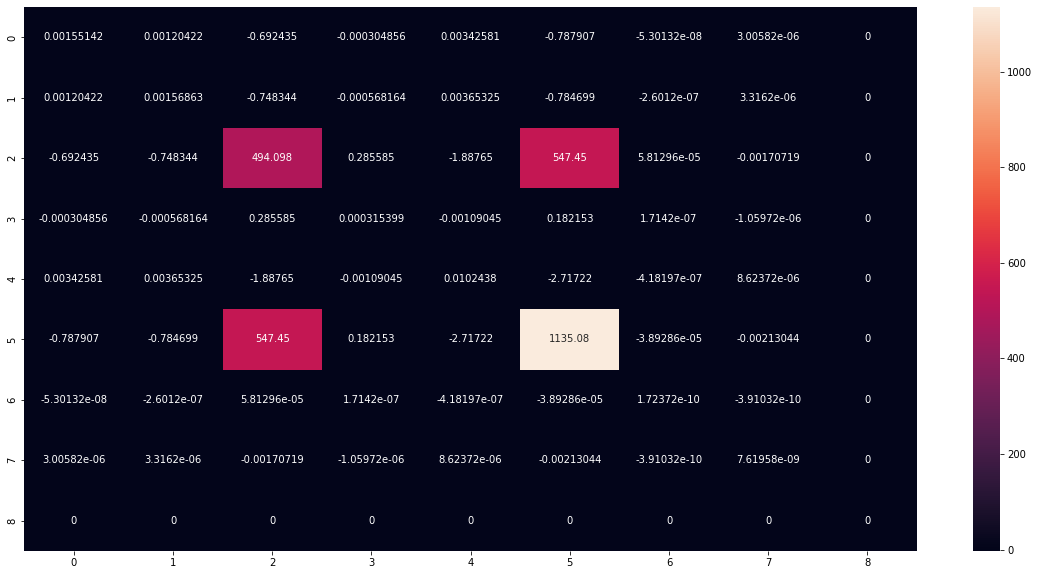

observations shape:  (25, 9)
determinant:  7.925683783206993e-61
new determinant:  0.003944223075989007
trace:  1377.4915131619498


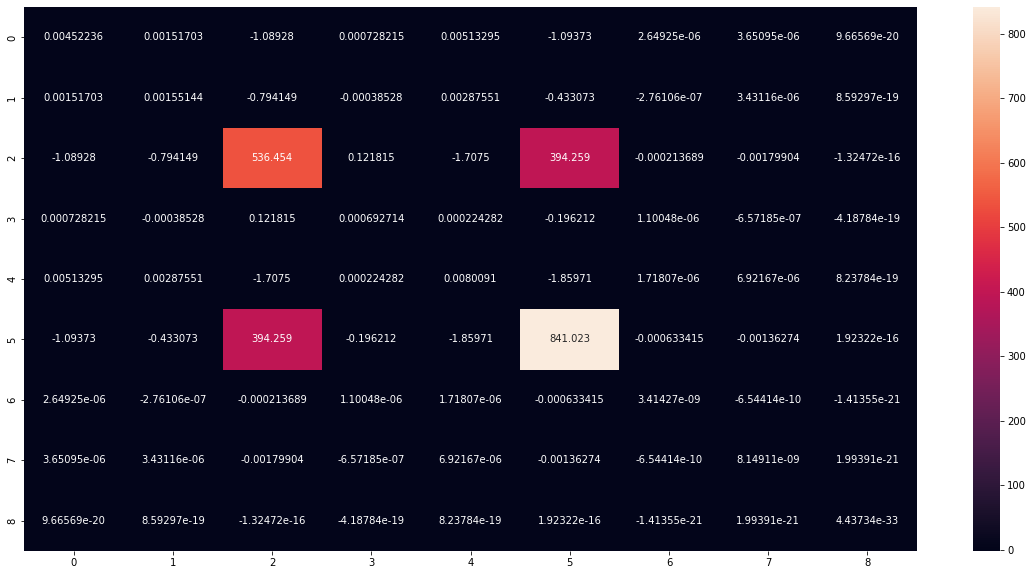

observations shape:  (25, 12)
determinant:  0.0
new determinant:  0.0
trace:  2845.1486817878736


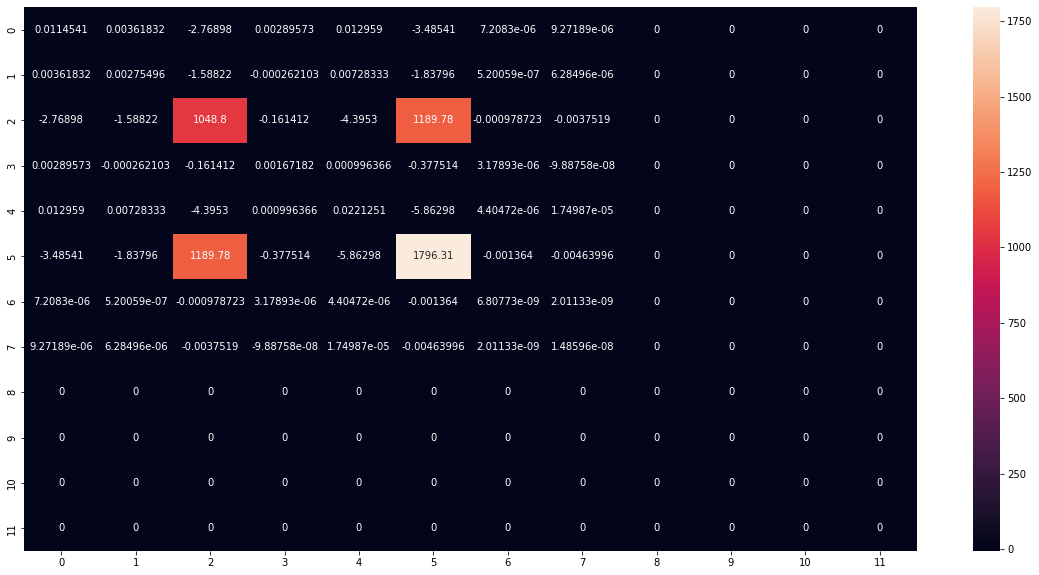

observations shape:  (25, 12)
determinant:  0.0
new determinant:  0.0
trace:  1377.4915131619498


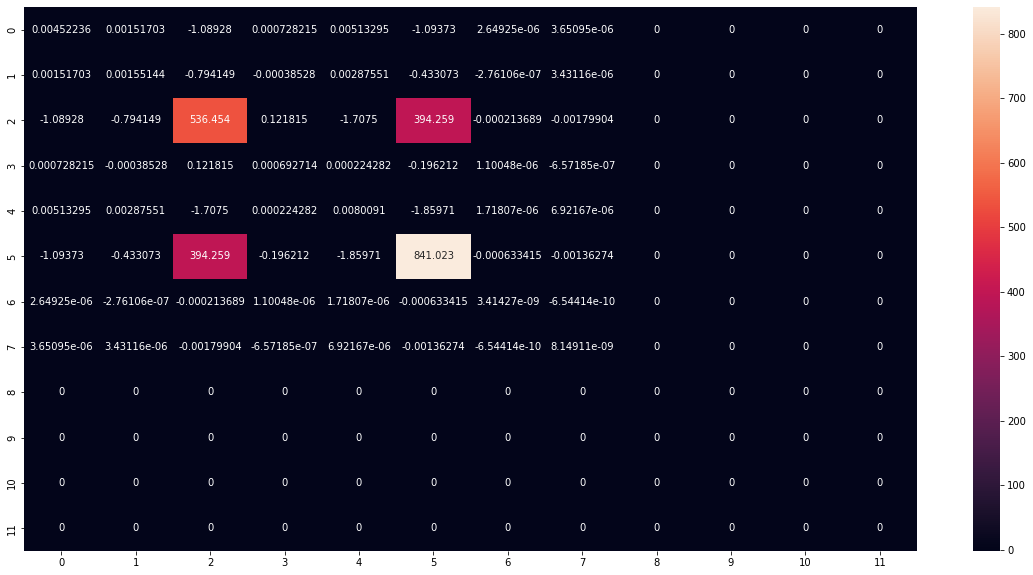

m for tangential:  [[ 1.76368834e+00  1.26274289e-01 -6.37910196e+01  2.06671785e-01
   9.75219986e-01  8.80103173e+01  4.94387327e-04  1.60875718e-03
   0.00000000e+00  0.00000000e+00  2.00054733e-03 -4.66732112e-05]
 [ 1.45668918e+00  4.40437546e-01 -1.26089766e+02 -1.34824173e-01
   1.17506459e+00  8.35717556e+01 -4.98018376e-04  2.46713821e-03
   0.00000000e+00  0.00000000e+00  2.20630047e-03 -8.29042295e-05]
 [ 1.76368834e+00  1.26274289e-01 -6.37910196e+01  2.06671785e-01
   9.75219986e-01  8.80103173e+01  4.94387327e-04  1.60875718e-03
   0.00000000e+00  0.00000000e+00  2.00054733e-03 -4.66732112e-05]
 [ 1.71644338e+00  2.12053783e-01 -8.01814100e+01 -4.24614362e-03
   1.35455198e+00  5.30412510e+01  3.70456058e-04  2.34706696e-03
   0.00000000e+00  0.00000000e+00  2.07761864e-03  2.07400478e-04]
 [ 1.91651621e+00  2.15464746e-01 -1.23021733e+02  2.78888304e-02
   1.25681432e+00  7.32856422e+01  4.67772247e-04  2.23000442e-03
   0.00000000e+00  0.00000000e+00  1.99650067e-03  1.

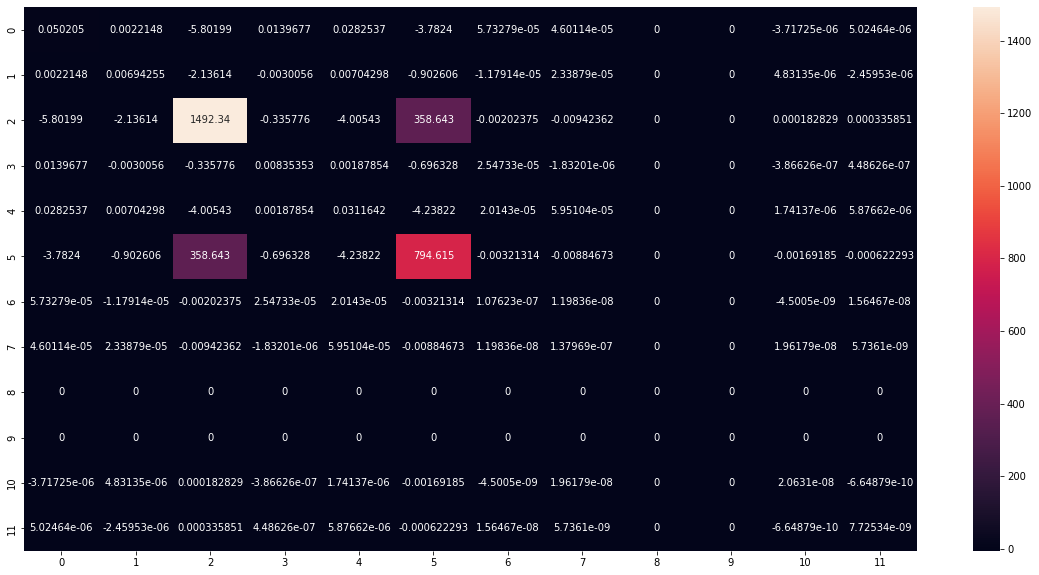

observations shape:  (25, 12)
determinant:  0.0
new determinant:  0.0
trace:  1377.4915131619498


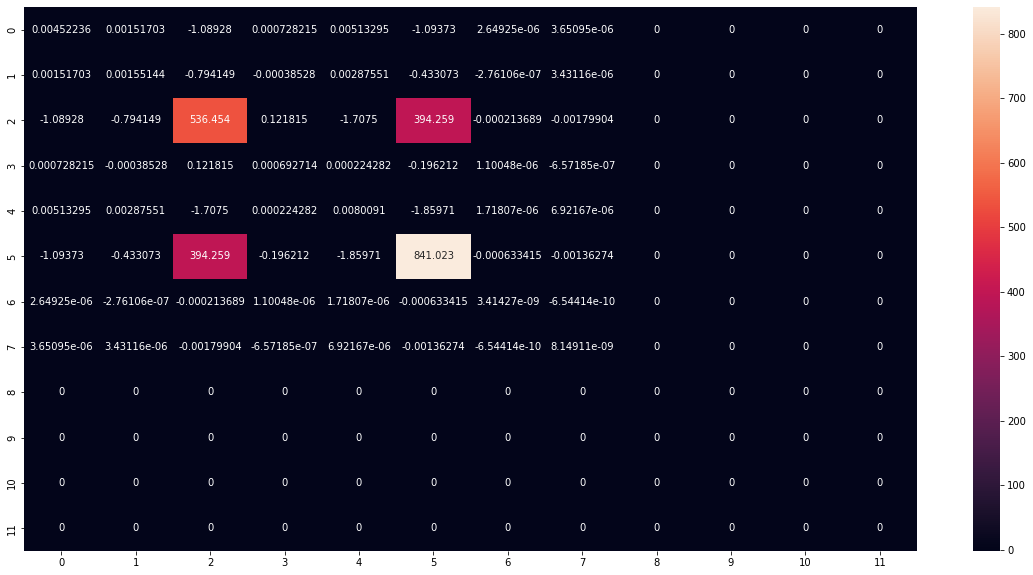

In [9]:
is_vis_ldmks = False
is_vis_cov = True
parse_results(train_vis_ldmks, train_matrices, train_errors, train_shape, is_vis_ldmks, is_vis_cov)